# **Prepare datasets**

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


Prepare data Train, from : https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view?usp=sharing

In [2]:
import pandas as pd
import sklearn
import re 


import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

from sklearn import metrics


import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('train_data.csv', sep=';')

In [4]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [5]:
df.shape

(11000, 2)

In [6]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

# **Text Normalization/Cleansing**

Cleansing strategy :
1. Lower the text
2. Remove unwanted symbol
3. Normalized slankword with Kamus Alay
4. Remove stopwords from NLTK indonesia

In [7]:
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    string = re.sub(r'([^\s\w]|_)+', ' ', string)
    return string

In [8]:
df['text_clean'] = df.text.apply(cleansing)

In [9]:
import sqlite3 as sql
conn1 = sql.connect('/content/dictionary_db.db')
df3 = pd.read_sql_query(''' select * from kamusalay_tb;''', conn1)

In [10]:
#Normalize based on kamus Alay
df3_dict = df3.set_index('alay',drop=True).to_dict()['normal']
pattern = r"\b(" + "|".join(re.escape(k) for k in df3_dict) + r")\b"
df['text_clean'] = df['text_clean'].str.replace(pattern, lambda m: df3_dict[m.group(0)], regex=True)

In [11]:
# !pip install Sastrawi
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# stop_factory = StopWordRemoverFactory()
# more_stopword = ['dengan','ia','bahwa','oleh']
# data = stop_factory.get_stop_words()+more_stopword
# stopword = stop_factory.create_stop_word_remover()
# print(data)

In [12]:
# #Remove stopwords based on Sastrawi
# def remove_stopwords (text) :
#     text =' '.join(word for word in text.split() if word not in data)
#     return text

In [13]:
# Downloads the data.
import nltk
nltk.download('stopwords')


# Using the stopwords.
from nltk.corpus import stopwords

# Initialize the stopwords
# stoplist = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#Remove stopwords based on NLTK
def remove_stopwords (text) :
    text =' '.join(word for word in text.split() if word not in nltk.corpus.stopwords.words('indonesian'))
    return text

In [15]:
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))

In [16]:
df.sample(50)

,text,label,text_clean
5513,ri targetkan angka perdagangan dengan vietnam ...,neutral,ri targetkan angka perdagangan vietnam rupiah ...
303,"gerai minuman di foodcourt griya metro , pilih...",positive,gerai minuman foodcourt griya metro pilihan mi...
9444,ini ada restoran favorit saya . letak nya tida...,positive,restoran favorit letak nya kesan dago coba deh...
4770,tempat nya strategis . porsi nya banyak dan en...,negative,nya strategis porsi nya enak kali kesan tingga...
2796,suasana dan tempat oke banget dari saya masih ...,positive,suasana oke banget zaman kuliah berkeluarga me...
5596,jokowi sayang dan cinta kepada rakyat nya,positive,jokowi sayang cinta rakyat nya
7188,saya sengaja memilih roti bakar dan kopi di ea...,positive,sengaja memilih roti bakar kopi eaton express ...
10224,handphone samsung milik ku benar-benar bagus d...,positive,handphone samsung milik ku bagus awet
6256,tempat ini terkenal banget di kalangan mahasis...,positive,terkenal banget kalangan mahasiswa enak harga ...
6345,mahal . pilhan makanan biasa saja . tidak ada ...,negative,mahal pilhan makanan spesial nasi rames puluha...


Sortir data dan label berdasarkan sentimen

In [17]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [18]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# **Feature Extraction**

In [19]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer_lstm.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)


tokenizer_lstm.pickle has created!


In [20]:
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

x_pad_sequences.pickle has created!


In [21]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset 80% for train and 20% for test.

In [22]:
file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Training**

In [29]:
embed_dim = 100
units = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.1))

# neural network
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(128, kernel_regularizer='L1L2', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 78, 100)           10000000  
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dense_24 (Dense)            (None, 256)               33024     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                      

# Evaluation




## Confussion Matrix, Accuracy, F1, Recall, Precision

In [30]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 4ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       685
           1       0.65      0.74      0.69       233
           2       0.84      0.96      0.89      1282

    accuracy                           0.83      2200
   macro avg       0.80      0.77      0.77      2200
weighted avg       0.84      0.83      0.82      2200



## Cross Validation

In [31]:

kf = KFold(n_splits=5,random_state=30,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 128

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.1))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(128, kernel_regularizer='L1L2', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 3ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       685
           1       0.73      0.70      0.71       233
           2       0.89      0.89      0.89      1282

    accuracy                           0.83      2200
   macro avg       0.79      0.79      0.79      2200
weighted avg       0.83      0.83      0.83      2200

69/69 [==============================] - 1s 4ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       685
           1       0.75      0.73      0.74       233
           2       0.89      0.91      0.90      1282

    accuracy                           0.85      2200
   macro avg       0.82      0.80      0.81      2200
weighted avg       0.85      0.85      0.85      2200

69/69 [==============================] - 1s 3ms/step
Training ke- 3
              precision    recall 

Check the accuracy in avg

## Visualization

For evaluation, use "Visualization", to find best training performance based on visualization direction.

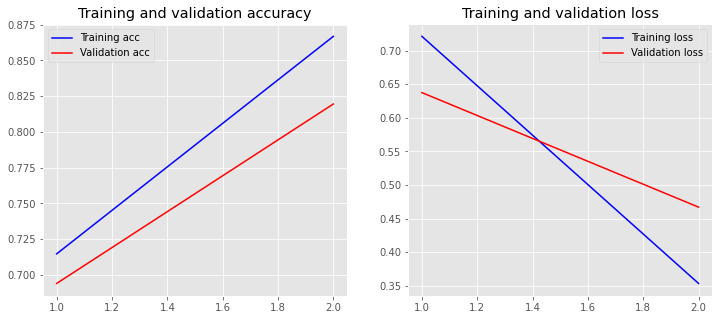

In [32]:
# history.history

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [33]:
model.save('model_lstm.h5')
print("Model has created!")

Model has created!


# Predict

In [34]:
import re 
from keras.models import load_model

input_text = """
# jalan-jalan ke pantai anyer walaupun angker saya senang dan takut juga sih
"""

def cleansing(string):
    string = string.lower()
    string = string.strip()
    string = re.sub(r'[^a-zA-z0-9]', ' ', string)
    string = re.sub(r'([^\s\w]|_)+', ' ', string)

    df3_dict = df3.set_index('alay',drop=True).to_dict()['normal']
    pattern = r"\b(" + "|".join(re.escape(k) for k in df3_dict) + r")\b"
    string = re.sub(pattern, lambda m: df3_dict[m.group(0)], string)

    remove_stopword = lambda x : ' '.join(word for word in x.split() if word not in nltk.corpus.stopwords.words('indonesian'))
    string = remove_stopword(string)

    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])
print("Prediction: ",prediction)


1/1 [==============================] - 0s 411ms/step
Text:  jalan jalan pantai anyer angker senang takut sih
Sentiment:  positive
Prediction:  [[0.3410253  0.00540123 0.6535735 ]]
